### CGAN  on MNIST

DCGAN is a Generative Adversarial Network (GAN) using CNN.

1. The discriminator learns to discriminate real from fake images.
2. The generator tries to fool the discriminator by generating fake images.
3. The generator + discriminator form an adversarial network.
4. DCGAN trains the discriminator and adversarial networks alternately.

During training, not only the discriminator learns to distinguish real from
fake images, it also coaches the generator part of the Adversarial network on how
to improve its ability to generate fake images.

In [0]:
import tensorflow as tf

import numpy as np
import math
import matplotlib.pyplot as plt
import os

#### Buiding a Generator Model

Build a model using layers of BatchNorm-ReLU-Conv2DTranpose to generate fake images

In [0]:
def build_generator(noise_inputs, label_inputs, image_size=28):
            
    #Concatenate both noise and labels
    x = tf.keras.layers.concatenate([noise_inputs, label_inputs], axis=1)
    
    #Increase dimensions and resize to 3D to feed it to Conv2DTranspose layer
    x = tf.keras.layers.Dense(7 * 7 * 128)(x)
    x = tf.keras.layers.Reshape((7, 7,128))(x)
    
    #Use ConvTranspose
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(128, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(32, kernel_size=[5,5], strides=1, padding='same')(x)
    
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(1, kernel_size=[5,5], strides=1, padding='same')(x)
    
    #Output layer for Generator
    x = tf.keras.layers.Activation('sigmoid')(x)
    
    generator = tf.keras.models.Model([noise_inputs, label_inputs], x, name='generator')
    
    return generator

#### Building a Discriminator

In [0]:
def build_discriminator(image_inputs, label_inputs, image_size=28):
    
    #Network parameters
    filter_size = 5
    num_filters = [32, 64, 128, 256]
    stride_size = [2, 2, 2, 1]
    
    #Build the network
    x = image_inputs
    
    #Make label_inputs of same size as image_inputs for concatenation
    y = tf.keras.layers.Dense(28*28)(label_inputs)
    y = tf.keras.layers.Reshape((28,28,1))(y)
    
    x = tf.keras.layers.concatenate([x, y])
    
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=[5,5], strides=2, padding='same')(x)
    
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Conv2D(256, kernel_size=[5,5], strides=1, padding='same')(x)
    
    #Flatten the output and build an output layer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    #Build Model
    discriminator = tf.keras.models.Model([image_inputs, label_inputs],
                                          x, name='discriminator')
    
    return discriminator

#### Building Models for Training

In [0]:
def build_models():
    
    noise_size = 100
    lr = 2e-4
    decay = 6e-8
    
    #Build input layers
    noise_inputs = tf.keras.layers.Input(shape=(noise_size,))
    label_inputs = tf.keras.layers.Input(shape=(10,))
    image_inputs = tf.keras.layers.Input(shape=(28, 28, 1,))
    
    #Build Base Discriminator model    
    base_discriminator = build_discriminator(image_inputs, label_inputs)
    
    #Define discriminator, optimizer and compile model
    discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    optimizer = tf.keras.optimizers.RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    
    #Build Generator model
    generator = build_generator(noise_inputs, label_inputs)
    
    #Build Frozen Discriminator
    frozen_discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                          outputs=base_discriminator.outputs)
    #Freeze the weights of discriminator during adversarial training
    frozen_discriminator.trainable = False

    #Build Adversarial model
    optimizer = tf.keras.optimizers.RMSprop(lr=lr * 0.5, decay=decay * 0.5)
        
    #Adversarial = generator + discriminator
    adversarial = tf.keras.models.Model([noise_inputs, label_inputs],
                                        frozen_discriminator([generator([noise_inputs, label_inputs]), label_inputs]))
    
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])    
    
    return generator, discriminator, adversarial

#### Training Discriminator and Adversarial Models

In [0]:
def train_gan(generator, discriminator, adversarial, noise_size=100):
    
    #Training parameters
    batch_size = 64
    train_steps = 10000
    image_size = 28
    num_labels = 10
    
    # load MNIST dataset
    (train_x, train_y), (_, _) = tf.keras.datasets.mnist.load_data()
    #Make it 3D dataset
    train_x = np.reshape(train_x, [-1, image_size, image_size, 1])
    #Standardize data : 0 to 1
    train_x = train_x.astype('float32') / 255
    
    #Convert labels to one-hot encoding
    train_y = tf.keras.utils.to_categorical(train_y)
    
    #Input for testing generator at different intervals, we will generate 16 images
    test_noise_input = np.random.uniform(-1.0,1.0, size=[16, noise_size])
    test_fake_labels = np.eye(num_labels)[np.random.choice(num_labels, 16)]
    
    #Start training
    for i in range(train_steps):
        
        #Train DISCRIMATOR
        
        #1. Get fake images from Generator
        noise_input = np.random.uniform(-1.0,1.0, size=[batch_size, noise_size])
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)]
        fake_images = generator.predict([noise_input, fake_labels])
        
        
        #2. Get real images and labels from training set
        img_indexes = np.random.randint(0, train_x.shape[0], size=batch_size)
        real_images = train_x[img_indexes]
        real_labels = train_y[img_indexes]
        
        #3. Prepare input for training Discriminator
        X_images = np.concatenate((real_images, fake_images))
        X_labels = np.concatenate((real_labels, fake_labels))
        
        #4. Labels for training
        y_real = np.ones((batch_size, 1))
        y_fake = np.zeros((batch_size, 1))
        y = np.concatenate((y_real, y_fake))
        
        #5. Train Discriminator
        d_loss, d_acc = discriminator.train_on_batch([X_images, X_labels], y)
        
        
        #Train ADVERSARIAL Network
        
        #1. Prepare input - create a new batch of noise
        X_noise = np.random.uniform(-1.0,1.0, size=[batch_size, noise_size])
        X_fake_labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)]
        
        #2. Prepare labels - training Adversarial network to lie :) - All 1s
        y = np.ones((batch_size, 1))
        
        #3. Train - Pls note Discrimator is not getting trained here
        a_loss, a_acc = adversarial.train_on_batch([X_noise, X_fake_labels], y)
        
        if i % 100 == 0:
            #Print loss and Accuracy for both networks
            print("%s [Discriminator loss: %f, acc: %f, Adversarial loss: %f, acc: %f]" % (i, d_loss, d_acc, a_loss, a_acc) )
        
        #Save generated images to see how well Generator is doing
        if (i+1) % 500 == 0:
            
            #Generate 16 images
            fake_images = generator.predict([test_noise_input, test_fake_labels])
            
            #Display images
            plot_images(fake_images, i+1)
            
    #Save Generator model
    generator.save('mnist_generator_cgan.h5')    

#### Save generator images

In [0]:
def plot_images(fake_images, step):
    
    plt.figure(figsize=(2.2, 2.2))
    num_images = fake_images.shape[0]
    
    image_size = fake_images.shape[1]
    rows = int(math.sqrt(fake_images.shape[0]))
    
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(fake_images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()    

### Start GAN Training

In [7]:
G, D, A = build_models()

W0802 09:14:27.726671 140509372999552 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0802 09:14:27.878652 140509372999552 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
G.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 6272)         696192      concatenate_1[0][0]      

In [9]:
D.summary()

W0802 09:14:28.611183 140509372999552 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 784)          8624        input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 1)    0           dense[0][0]                      
______________________________________________________________________________________________

In [10]:
A.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 28, 28, 1)    1364225     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            1090001     generator[1][0]            

W0802 09:14:31.896278 140509372999552 training.py:2197] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


0 [Discriminator loss: 0.694112, acc: 0.492188, Adversarial loss: 0.801820, acc: 0.000000]
100 [Discriminator loss: 0.000152, acc: 1.000000, Adversarial loss: 0.000001, acc: 1.000000]
200 [Discriminator loss: 0.377716, acc: 0.757812, Adversarial loss: 8.599297, acc: 0.000000]
300 [Discriminator loss: 0.122467, acc: 1.000000, Adversarial loss: 2.479136, acc: 0.000000]
400 [Discriminator loss: 0.107939, acc: 0.976562, Adversarial loss: 1.178940, acc: 0.328125]


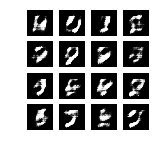

500 [Discriminator loss: 0.549380, acc: 0.710938, Adversarial loss: 1.938854, acc: 0.078125]
600 [Discriminator loss: 0.537263, acc: 0.773438, Adversarial loss: 0.947894, acc: 0.312500]
700 [Discriminator loss: 0.520653, acc: 0.796875, Adversarial loss: 0.683148, acc: 0.562500]
800 [Discriminator loss: 0.470119, acc: 0.804688, Adversarial loss: 1.170668, acc: 0.156250]
900 [Discriminator loss: 0.440064, acc: 0.820312, Adversarial loss: 0.846390, acc: 0.421875]


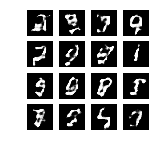

1000 [Discriminator loss: 0.478026, acc: 0.812500, Adversarial loss: 1.371534, acc: 0.156250]
1100 [Discriminator loss: 0.513116, acc: 0.750000, Adversarial loss: 0.910743, acc: 0.375000]
1200 [Discriminator loss: 0.545297, acc: 0.742188, Adversarial loss: 1.363975, acc: 0.125000]
1300 [Discriminator loss: 0.563138, acc: 0.671875, Adversarial loss: 1.805813, acc: 0.015625]
1400 [Discriminator loss: 0.625029, acc: 0.664062, Adversarial loss: 0.642708, acc: 0.609375]


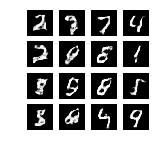

1500 [Discriminator loss: 0.507342, acc: 0.789062, Adversarial loss: 1.234685, acc: 0.171875]
1600 [Discriminator loss: 0.558947, acc: 0.687500, Adversarial loss: 2.196408, acc: 0.031250]
1700 [Discriminator loss: 0.560327, acc: 0.687500, Adversarial loss: 0.792264, acc: 0.500000]
1800 [Discriminator loss: 0.604224, acc: 0.632812, Adversarial loss: 0.794539, acc: 0.531250]
1900 [Discriminator loss: 0.611142, acc: 0.640625, Adversarial loss: 1.509028, acc: 0.093750]


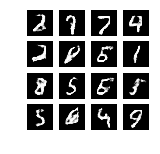

2000 [Discriminator loss: 0.566835, acc: 0.695312, Adversarial loss: 0.983654, acc: 0.265625]
2100 [Discriminator loss: 0.527763, acc: 0.734375, Adversarial loss: 1.421461, acc: 0.062500]
2200 [Discriminator loss: 0.535326, acc: 0.750000, Adversarial loss: 1.212908, acc: 0.171875]
2300 [Discriminator loss: 0.598647, acc: 0.664062, Adversarial loss: 0.759739, acc: 0.500000]
2400 [Discriminator loss: 0.603628, acc: 0.664062, Adversarial loss: 1.531390, acc: 0.125000]


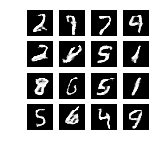

2500 [Discriminator loss: 0.574106, acc: 0.703125, Adversarial loss: 1.001818, acc: 0.359375]
2600 [Discriminator loss: 0.620306, acc: 0.640625, Adversarial loss: 1.199408, acc: 0.125000]
2700 [Discriminator loss: 0.654727, acc: 0.632812, Adversarial loss: 1.302662, acc: 0.125000]
2800 [Discriminator loss: 0.599004, acc: 0.703125, Adversarial loss: 0.961336, acc: 0.296875]
2900 [Discriminator loss: 0.617279, acc: 0.632812, Adversarial loss: 1.016735, acc: 0.343750]


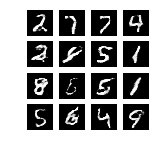

3000 [Discriminator loss: 0.662641, acc: 0.601562, Adversarial loss: 1.131225, acc: 0.187500]
3100 [Discriminator loss: 0.648507, acc: 0.601562, Adversarial loss: 0.711258, acc: 0.609375]
3200 [Discriminator loss: 0.659307, acc: 0.601562, Adversarial loss: 0.831495, acc: 0.406250]
3300 [Discriminator loss: 0.688432, acc: 0.554688, Adversarial loss: 0.924420, acc: 0.312500]
3400 [Discriminator loss: 0.636200, acc: 0.664062, Adversarial loss: 1.045472, acc: 0.218750]


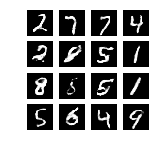

3500 [Discriminator loss: 0.666645, acc: 0.617188, Adversarial loss: 1.179076, acc: 0.109375]
3600 [Discriminator loss: 0.570303, acc: 0.726562, Adversarial loss: 0.837130, acc: 0.406250]
3700 [Discriminator loss: 0.592808, acc: 0.632812, Adversarial loss: 1.153443, acc: 0.156250]
3800 [Discriminator loss: 0.623413, acc: 0.656250, Adversarial loss: 1.015572, acc: 0.250000]
3900 [Discriminator loss: 0.585790, acc: 0.671875, Adversarial loss: 1.009169, acc: 0.328125]


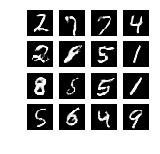

4000 [Discriminator loss: 0.625748, acc: 0.601562, Adversarial loss: 0.875479, acc: 0.296875]
4100 [Discriminator loss: 0.662119, acc: 0.617188, Adversarial loss: 1.081779, acc: 0.203125]
4200 [Discriminator loss: 0.613345, acc: 0.656250, Adversarial loss: 0.731920, acc: 0.515625]
4300 [Discriminator loss: 0.620402, acc: 0.648438, Adversarial loss: 1.089888, acc: 0.156250]
4400 [Discriminator loss: 0.649410, acc: 0.632812, Adversarial loss: 1.049948, acc: 0.234375]


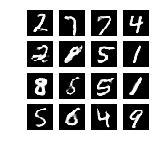

4500 [Discriminator loss: 0.609765, acc: 0.625000, Adversarial loss: 0.816448, acc: 0.390625]
4600 [Discriminator loss: 0.646673, acc: 0.593750, Adversarial loss: 0.880990, acc: 0.296875]
4700 [Discriminator loss: 0.633129, acc: 0.671875, Adversarial loss: 0.782688, acc: 0.437500]
4800 [Discriminator loss: 0.684071, acc: 0.570312, Adversarial loss: 0.702375, acc: 0.453125]
4900 [Discriminator loss: 0.603220, acc: 0.648438, Adversarial loss: 0.788139, acc: 0.359375]


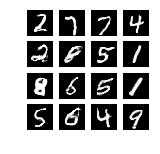

5000 [Discriminator loss: 0.614818, acc: 0.656250, Adversarial loss: 0.843979, acc: 0.406250]
5100 [Discriminator loss: 0.601475, acc: 0.671875, Adversarial loss: 0.837909, acc: 0.421875]
5200 [Discriminator loss: 0.636384, acc: 0.640625, Adversarial loss: 0.787615, acc: 0.390625]
5300 [Discriminator loss: 0.730798, acc: 0.531250, Adversarial loss: 0.671689, acc: 0.640625]
5400 [Discriminator loss: 0.576497, acc: 0.703125, Adversarial loss: 0.959845, acc: 0.281250]


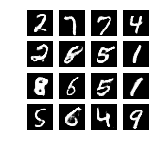

5500 [Discriminator loss: 0.642214, acc: 0.601562, Adversarial loss: 1.027122, acc: 0.250000]
5600 [Discriminator loss: 0.699645, acc: 0.617188, Adversarial loss: 1.111093, acc: 0.109375]
5700 [Discriminator loss: 0.616988, acc: 0.687500, Adversarial loss: 0.823569, acc: 0.343750]
5800 [Discriminator loss: 0.635810, acc: 0.617188, Adversarial loss: 0.885213, acc: 0.312500]
5900 [Discriminator loss: 0.628591, acc: 0.640625, Adversarial loss: 1.065688, acc: 0.171875]


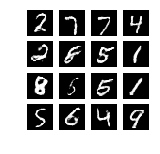

6000 [Discriminator loss: 0.645646, acc: 0.632812, Adversarial loss: 0.763621, acc: 0.484375]
6100 [Discriminator loss: 0.642449, acc: 0.609375, Adversarial loss: 0.796262, acc: 0.375000]
6200 [Discriminator loss: 0.640031, acc: 0.585938, Adversarial loss: 0.842701, acc: 0.343750]
6300 [Discriminator loss: 0.619821, acc: 0.648438, Adversarial loss: 0.803699, acc: 0.515625]
6400 [Discriminator loss: 0.648492, acc: 0.632812, Adversarial loss: 0.751450, acc: 0.531250]


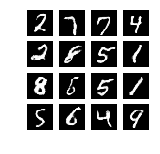

6500 [Discriminator loss: 0.610560, acc: 0.687500, Adversarial loss: 0.819577, acc: 0.359375]
6600 [Discriminator loss: 0.673851, acc: 0.570312, Adversarial loss: 0.638142, acc: 0.609375]
6700 [Discriminator loss: 0.651738, acc: 0.546875, Adversarial loss: 0.823491, acc: 0.453125]
6800 [Discriminator loss: 0.624913, acc: 0.648438, Adversarial loss: 1.043083, acc: 0.171875]
6900 [Discriminator loss: 0.649678, acc: 0.632812, Adversarial loss: 1.061958, acc: 0.218750]


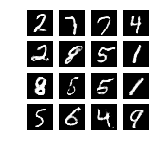

7000 [Discriminator loss: 0.651838, acc: 0.671875, Adversarial loss: 0.689178, acc: 0.531250]
7100 [Discriminator loss: 0.605541, acc: 0.679688, Adversarial loss: 0.879732, acc: 0.296875]
7200 [Discriminator loss: 0.658416, acc: 0.609375, Adversarial loss: 0.846107, acc: 0.296875]
7300 [Discriminator loss: 0.621020, acc: 0.632812, Adversarial loss: 0.864598, acc: 0.250000]
7400 [Discriminator loss: 0.603991, acc: 0.687500, Adversarial loss: 0.932630, acc: 0.250000]


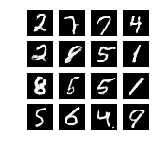

7500 [Discriminator loss: 0.635180, acc: 0.593750, Adversarial loss: 0.969023, acc: 0.218750]
7600 [Discriminator loss: 0.643788, acc: 0.640625, Adversarial loss: 0.886432, acc: 0.359375]
7700 [Discriminator loss: 0.655341, acc: 0.617188, Adversarial loss: 0.712137, acc: 0.546875]
7800 [Discriminator loss: 0.669949, acc: 0.585938, Adversarial loss: 1.136522, acc: 0.156250]
7900 [Discriminator loss: 0.663303, acc: 0.601562, Adversarial loss: 1.052566, acc: 0.234375]


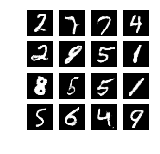

8000 [Discriminator loss: 0.654631, acc: 0.617188, Adversarial loss: 0.851762, acc: 0.328125]
8100 [Discriminator loss: 0.617960, acc: 0.671875, Adversarial loss: 0.909577, acc: 0.296875]
8200 [Discriminator loss: 0.634967, acc: 0.578125, Adversarial loss: 0.834629, acc: 0.390625]
8300 [Discriminator loss: 0.639045, acc: 0.640625, Adversarial loss: 0.685102, acc: 0.609375]
8400 [Discriminator loss: 0.641133, acc: 0.601562, Adversarial loss: 0.661137, acc: 0.546875]


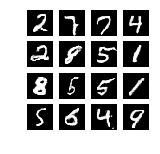

8500 [Discriminator loss: 0.633643, acc: 0.625000, Adversarial loss: 0.954151, acc: 0.265625]
8600 [Discriminator loss: 0.639541, acc: 0.601562, Adversarial loss: 0.978479, acc: 0.140625]
8700 [Discriminator loss: 0.645495, acc: 0.593750, Adversarial loss: 0.965699, acc: 0.265625]
8800 [Discriminator loss: 0.612424, acc: 0.703125, Adversarial loss: 0.863659, acc: 0.406250]
8900 [Discriminator loss: 0.652319, acc: 0.570312, Adversarial loss: 0.724550, acc: 0.500000]


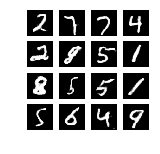

9000 [Discriminator loss: 0.663690, acc: 0.601562, Adversarial loss: 0.703845, acc: 0.453125]
9100 [Discriminator loss: 0.624589, acc: 0.625000, Adversarial loss: 0.862204, acc: 0.312500]
9200 [Discriminator loss: 0.618932, acc: 0.648438, Adversarial loss: 0.947717, acc: 0.265625]
9300 [Discriminator loss: 0.617262, acc: 0.664062, Adversarial loss: 0.869332, acc: 0.312500]
9400 [Discriminator loss: 0.677133, acc: 0.601562, Adversarial loss: 0.607738, acc: 0.687500]


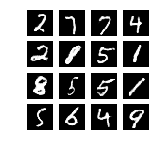

9500 [Discriminator loss: 0.623252, acc: 0.671875, Adversarial loss: 0.774298, acc: 0.453125]
9600 [Discriminator loss: 0.684401, acc: 0.585938, Adversarial loss: 1.062483, acc: 0.171875]
9700 [Discriminator loss: 0.649664, acc: 0.640625, Adversarial loss: 0.750321, acc: 0.453125]
9800 [Discriminator loss: 0.607421, acc: 0.656250, Adversarial loss: 0.740129, acc: 0.546875]
9900 [Discriminator loss: 0.640402, acc: 0.671875, Adversarial loss: 0.850167, acc: 0.375000]


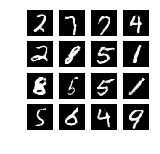

In [11]:
train_gan(G, D, A)

In [0]:
def test_generator(generator, label):
    
    test_noise_input = np.random.uniform(-1.0,1.0, size=[16, 100])
    test_fake_labels = np.eye(10)[np.repeat(label, 16)]
    fake_images = generator.predict([test_noise_input, test_fake_labels])
    plot_images(fake_images, 0)

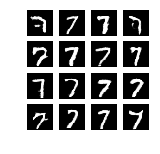

In [13]:
test_generator(G, 7)

In [14]:
np.eye(10)[np.repeat(7, 16)]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])